Here we take the cadherin interactome data and the lysine modification data and look for enrichment of lysine acylations in the cadherin interactome

In [2]:
import os
import collections

import pandas as pd
import numpy as np
from scipy import stats

import CGAT.IOTools as IOTools

from time import gmtime, strftime

%load_ext rpy2.ipython

In [3]:
results_dir = "./results/"
raw_dir = "../raw"
lysine_mod_inf = os.path.join(results_dir, 'lysine_modification.tsv')

cadherin_inf = os.path.join(results_dir, "cadherine_proteins.tsv")
cadherin_glass_inf = os.path.join(results_dir, "ecadherin_glass.tsv")
cadherin_biotin_inf = os.path.join(results_dir, "ecadherin_biotin.tsv")

paxdf_whole_inf = os.path.join(raw_dir, '10090-WHOLE_ORGANISM-integrated.txt')
paxdf_liver_inf = os.path.join(raw_dir, '10090-LIVER-integrated.txt')
paxdf_heart_inf = os.path.join(raw_dir, '10090-HEART-integrated.txt')

lfq_inf = os.path.join(raw_dir, 'Deep_Proteomic_LBQ.csv')

In [4]:
lysine_df = pd.read_table(lysine_mod_inf, sep="\t")
print(lysine_df.head())
print(lysine_df[lysine_df['Protein']=='Q9JLT4'])

def pivotResetAndBoolify(index):
    lysine_pivot = lysine_df.pivot_table(
        values='ratio', index=index, columns='Modification', aggfunc=lambda x: len(x)>0)
    lysine_pivot = lysine_pivot.fillna(0)
    lysine_pivot.reset_index(inplace=True)
    lysine_pivot.columns.name = None
    
    return lysine_pivot


lysine_protein_df = pivotResetAndBoolify(['Protein'])
lysine_protein_study_df = pivotResetAndBoolify(['Protein', 'Reference'])
lysine_position_df = pivotResetAndBoolify(['Protein', 'Position'])

print(lysine_protein_df[lysine_protein_df['Protein']=='Q9JLT4'])
print(lysine_protein_study_df[lysine_protein_study_df['Protein']=='Q9JLT4'])
print(lysine_position_df[lysine_position_df['Protein']=='Q9JLT4'])

  Protein  Position   Modification             Reference  ratio  p_value
0  Q9JLT4       337  succinylation  Sadhukhan_et_al_2016   1.47     -1.0
1  Q61425       179  succinylation  Sadhukhan_et_al_2016   1.07     -1.0
2  Q61425       241  succinylation  Sadhukhan_et_al_2016   1.33     -1.0
3  Q9JLZ3       179  succinylation  Sadhukhan_et_al_2016   4.70     -1.0
4  Q9CZU6       450  succinylation  Sadhukhan_et_al_2016  57.68     -1.0
      Protein  Position   Modification             Reference  ratio  p_value
0      Q9JLT4       337  succinylation  Sadhukhan_et_al_2016   1.47     -1.0
5186   Q9JLT4        64  glutarylation        Tan_et_al_2014  -1.00     -1.0
5187   Q9JLT4       337  glutarylation        Tan_et_al_2014  -1.00     -1.0
5188   Q9JLT4       329  glutarylation        Tan_et_al_2014  -1.00     -1.0
5189   Q9JLT4       285  glutarylation        Tan_et_al_2014  -1.00     -1.0
5190   Q9JLT4       137  glutarylation        Tan_et_al_2014  -1.00     -1.0
9032   Q9JLT4       337

In [5]:
print(lysine_position_df[lysine_df['Reference']=='Sadhukhan_et_al_2016'].shape)
print(lysine_protein_study_df[lysine_protein_study_df['Reference']=='Sadhukhan_et_al_2016'].shape)

(119, 7)
(50, 7)


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [6]:
lysine_position_df['competitive_modifications'] = [x==3 for x in lysine_position_df[
        ['acetylation', 'malonylation', 'succinylation']].apply(sum, 1).tolist()]

lysine_protein_df['all_modifications'] = [x == 3 for x in lysine_protein_df[
        ['acetylation', 'malonylation', 'succinylation']].apply(sum, 1)]

print(lysine_position_df.head(2))
print(lysine_protein_df.head(2))

#lysine_df_pivot.to_csv(os.path.join(results_dir, 'lysine_modification_summary.tsv'), sep='\t')

  Protein  Position  acetylation  glutarylation  malonylation  succinylation  \
0  A0AUV1         5          1.0            0.0           0.0            0.0   
1  A0AUV1         9          1.0            0.0           0.0            0.0   

   succinylation_SIRT5_KO competitive_modifications  
0                     0.0                     False  
1                     0.0                     False  
  Protein  acetylation  glutarylation  malonylation  succinylation  \
0  A0AUV1          1.0            0.0           0.0            0.0   
1  A0JLP6          1.0            0.0           0.0            0.0   

   succinylation_SIRT5_KO all_modifications  
0                     0.0             False  
1                     0.0             False  


Next we use the localisations from the hyperlopit data


In [7]:
lopit_df = pd.read_table('~/WT/NML/hyperLOPIT-enrichment/R/hl_subset.tsv', sep='\t')
lopit_df = lopit_df[['uniprot.accession', 'Final.Localization.Assignment']]
print(lopit_df.columns)
print(lopit_df.shape)
print(lopit_df.head())

Index(['uniprot.accession', 'Final.Localization.Assignment'], dtype='object')
(4413, 2)
  uniprot.accession Final.Localization.Assignment
0            Q9JHU4                  unclassified
1            Q9ERU9           Nucleus - Chromatin
2            P26039            Actin cytoskeleton
3            Q8BTM8                  unclassified
4            A2ARV4                  unclassified


In [8]:
def readCadherin(infile, column_name, abundance_column=None, sep=","):
    df = pd.read_table(infile, sep=sep)
    df[column_name] = 1
    df = df[df['Mouse_uniprot_IDs'].notnull()]
    print(df.columns)
    
    if abundance_column:
        df = df[['Mouse_uniprot_IDs', column_name, abundance_column]]
    else:
        df = df[['Mouse_uniprot_IDs', column_name]]
    df.set_index('Mouse_uniprot_IDs', inplace=True)

    return df
    
cadherin_interactome_df  = readCadherin(
    cadherin_inf, "cadherin_interactome", sep=",")
ecadherin_glass_interactome_df = readCadherin(
    cadherin_glass_inf, "ecadherin_glass_interactome", "interactome_abundance",)
ecadherin_biotin_interactome_df = readCadherin(
    cadherin_biotin_inf, "ecadherin_biotin_interactome", "interactome_abundance")

ecadherin_glass_interactome_df.rename(
    columns={'interactome_abundance':'glass_interactome_abundance'}, inplace=True)
ecadherin_biotin_interactome_df.rename(
    columns={'interactome_abundance':'biotin_interactome_abundance'}, inplace=True)

print(ecadherin_glass_interactome_df.head())
print(len(set(cadherin_interactome_df.index)))
print(len(set(lopit_df['uniprot.accession'])))
print(len(set(cadherin_interactome_df.index).intersection
          (set(lopit_df['uniprot.accession']))))

ecadherin_biotin_interactome_df['biotin_rank'] = ecadherin_biotin_interactome_df[
    'biotin_interactome_abundance'].rank(ascending=False)
ecadherin_glass_interactome_df['glass_rank'] = ecadherin_glass_interactome_df[
    'glass_interactome_abundance'].rank(ascending=False)

print(ecadherin_biotin_interactome_df.head())
print(ecadherin_glass_interactome_df.head())

Index(['Mouse_uniprot_IDs', 'cadherin_interactome'], dtype='object')
Index(['Mouse_uniprot_IDs', 'Human_uniprot_IDs', 'interactome_abundance',
       'rank', 'ecadherin_glass_interactome'],
      dtype='object')
Index(['Mouse_uniprot_IDs', 'Human_uniprot_IDs', 'interactome_abundance',
       'rank', 'ecadherin_biotin_interactome'],
      dtype='object')
                   ecadherin_glass_interactome  glass_interactome_abundance
Mouse_uniprot_IDs                                                          
P10126                                       1                     6.333808
P68372                                       1                     2.546583
P68373                                       1                     2.252746
Q9D8N0                                       1                     1.795667
P62827                                       1                     1.763019
130
4413
76
                      ecadherin_biotin_interactome  \
Mouse_uniprot_IDs                             

Now we bring in the paxdb protein abundance data

In [9]:
ensembl2Uniprot = {}
with IOTools.openFile("../raw/MOUSE_10090_idmapping_selected.tab.gz", "r") as inf:
    for line in inf:
        line = line.strip().split("\t")
        try:
            proteins = line[20].split("; ")
            for protein in proteins:
                if len(protein) > 0:
                    ensembl2Uniprot[protein] = line[0]
        except:
            pass

def parseAbundance(infile, abundance_column_name='abundance'):
    abundance_df = pd.read_table(infile, sep="\t",comment='#', header=None, usecols=[1,2])

    abundance_df.columns = ["id", abundance_column_name]
    abundance_df['id'] = [x.split(".")[1] for x in abundance_df['id']]
    abundance_df['uniprot_id'] = [ensembl2Uniprot[x] if x in ensembl2Uniprot else "" for x in abundance_df['id']]
    abundance_df = abundance_df[[len(x) > 0 for x in abundance_df['uniprot_id']]]
    abundance_df = pd.DataFrame(
        abundance_df.groupby(["uniprot_id"])[abundance_column_name].agg(np.mean)).reset_index()
    #abundance_df['length'] = [protein_lengths[x] if x in protein_lengths else None
    #                      for x in abundance_df['uniprot_id']]
    abundance_df['binned_abundance'] = np.digitize(
        np.log10(abundance_df[abundance_column_name]+0.01), bins=np.arange(-3,4.5,0.5))
    abundance_df.set_index('uniprot_id', inplace=True)
    return abundance_df

full_abundance_df = parseAbundance(paxdf_whole_inf, "integrated_abundance")
liver_abundance_df = parseAbundance(paxdf_liver_inf, "liver_abundance")
heart_abundance_df = parseAbundance(paxdf_heart_inf, "heart_abundance")
print(full_abundance_df.head())
print(liver_abundance_df.head())
print(heart_abundance_df.head())


            integrated_abundance  binned_abundance
uniprot_id                                        
A0A023T778                34.000                10
A0A067XG46                 0.086                 4
A0A096P6K7                 0.228                 5
A0A0A0MQ68               101.000                11
A0A0A0MQ69                 1.810                 7
            liver_abundance  binned_abundance
uniprot_id                                   
A0A023T778            2.280                 7
A0A0A0MQ68          323.000                12
A0A0A0MQ76          295.000                11
A0A0A0MQ79            0.102                 5
A0A0A0MQ89            0.027                 4
            heart_abundance  binned_abundance
uniprot_id                                   
A0A023T778            2.210                 7
A0A0A0MQ68           45.900                10
A0A0A0MQ76           74.400                10
A0A0A0MQ79            0.835                 6
A0A0A0MQ89            0.000                 3

In [10]:
mef_abundance_df = pd.read_table("../raw/Deep_Proteomic_LBQ.csv", sep="\t",
                                 usecols=[
        'MEDIAN.LFQ.intensity.[log2].MEF', 'Majority.protein.IDs',
        'Unique peptides MEF_1', 'Unique peptides MEF_2', 'Unique peptides MEF_3'])

print(mef_abundance_df.shape)
mef_abundance_df = mef_abundance_df[mef_abundance_df['MEDIAN.LFQ.intensity.[log2].MEF']!='#VALUE!']
print(mef_abundance_df.shape)
mef_abundance_df['median_unique_pep'] = mef_abundance_df[[
            'Unique peptides MEF_1', 'Unique peptides MEF_2', 'Unique peptides MEF_3']].apply(np.median, axis=1)
mef_abundance_df = mef_abundance_df[mef_abundance_df['median_unique_pep']>2]
print(mef_abundance_df.shape)

print(mef_abundance_df.head())
print(mef_abundance_df.tail())

mef_abundance_df['MEDIAN.LFQ.intensity.[log2].MEF'] = mef_abundance_df['MEDIAN.LFQ.intensity.[log2].MEF'].astype(float)

mef_abundance_df['binned_abundance'] = np.digitize(
    mef_abundance_df['MEDIAN.LFQ.intensity.[log2].MEF'], bins=np.arange(25,35,1))
mef_abundance_df.set_index('Majority.protein.IDs', inplace=True)
print(mef_abundance_df.head())

(7950, 5)
(6040, 5)
(4239, 6)
     MEDIAN.LFQ.intensity.[log2].MEF  Unique peptides MEF_1  \
1912                           21.91                      5   
1922                           22.84                      4   
1926                           23.20                      3   
1928                           23.21                      4   
1931                           23.31                      3   

      Unique peptides MEF_2  Unique peptides MEF_3  \
1912                      3                      5   
1922                      5                      5   
1926                      3                      2   
1928                      4                      3   
1931                      2                      3   

                      Majority.protein.IDs  median_unique_pep  
1912                Q3TMU8;O35098;O35098-2                5.0  
1922                                P10493                5.0  
1926  E9QMC1;D3YUW7;P59242;P59242-2;E9Q611                3.0  
1928      

In [11]:
print(lopit_df.shape)


print(lysine_protein_study_df.shape)

merged_protein_df = pd.merge(lopit_df, lysine_protein_study_df.set_index("Protein"),
                     left_on='uniprot.accession', right_index=True, how='outer')
merged_protein_df['Final.Localization.Assignment'].fillna("Not in hyperLOPIT", inplace=True)

print(merged_protein_df.columns)
print(merged_protein_df.shape)
print(cadherin_interactome_df.shape)

merged_protein_df = pd.merge(merged_protein_df, cadherin_interactome_df,
                             left_on='uniprot.accession', right_index=True, how='outer')

#print(merged_protein_df['uniprot.accession'][0:10])
#print(ecadherin_glass_interactome_df['Mouse_uniprot_IDs'][0:10])
#print(ecadherin_biotin_interactome_df['Mouse_uniprot_IDs'][0:10])
print(merged_protein_df.shape)
print(ecadherin_glass_interactome_df.shape)

merged_protein_df = pd.merge(merged_protein_df, ecadherin_glass_interactome_df,
                             left_on='uniprot.accession', right_index=True, how='outer')

print(merged_protein_df.shape)
print(ecadherin_biotin_interactome_df.shape)

merged_protein_df = pd.merge(merged_protein_df, ecadherin_biotin_interactome_df,
                             left_on='uniprot.accession', right_index=True, how='outer')

#merged_protein_df['cadherin_interactome'].fillna(0, inplace=True)
#merged_protein_df['ecadherin_glass_interactome'].fillna(0, inplace=True)
#merged_protein_df['ecadherin_biotin_interactome'].fillna(0, inplace=True)
merged_protein_df['Final.Localization.Assignment'].fillna("Not in hyperLOPIT", inplace=True)
merged_protein_df['Reference'].fillna("NA", inplace=True)
merged_protein_df.fillna(0, inplace=True)

print(merged_protein_df.shape)
print(full_abundance_df.shape)

merged_protein_df = pd.merge(merged_protein_df, full_abundance_df,
                             left_on="uniprot.accession", right_index=True,
                             how='right')
#merged_protein_df.drop('Protein', axis=1, inplace=True)
print(merged_protein_df.shape)
print(merged_protein_df.head())

(4413, 2)
(6816, 7)
Index(['uniprot.accession', 'Final.Localization.Assignment', 'Reference',
       'acetylation', 'glutarylation', 'malonylation', 'succinylation',
       'succinylation_SIRT5_KO'],
      dtype='object')
(9793, 8)
(130, 1)
(9841, 9)
(1545, 3)
(10218, 12)
(406, 3)
(10326, 15)
(19023, 2)
(21272, 17)
  uniprot.accession Final.Localization.Assignment           Reference  \
0            Q9JHU4                  unclassified   Colaka_et_al_2015   
0            Q9JHU4                  unclassified  Nishida_et_al_2015   
0            Q9JHU4                  unclassified      Sol_et_al_2012   
0            Q9JHU4                  unclassified  Weinert_et_al_2013   
1            Q9ERU9           Nucleus - Chromatin   Colaka_et_al_2015   

   acetylation  glutarylation  malonylation  succinylation  \
0          0.0            0.0           1.0            0.0   
0          0.0            0.0           1.0            0.0   
0          1.0            0.0           0.0            0.0

In [12]:
merged_protein_df['Final.Localization.Assignment'] = merged_protein_df['Final.Localization.Assignment'].astype(str)
merged_protein_df['Reference'] = merged_protein_df['Reference'].astype(str)
merged_protein_df['ecadherin_biotin_interactome'].fillna(0, inplace=True)
merged_protein_df['ecadherin_glass_interactome'].fillna(0, inplace=True)
merged_protein_df['succinylation'].fillna(0, inplace=True)
merged_protein_df['cadherin_interactome'].fillna(0, inplace=True)

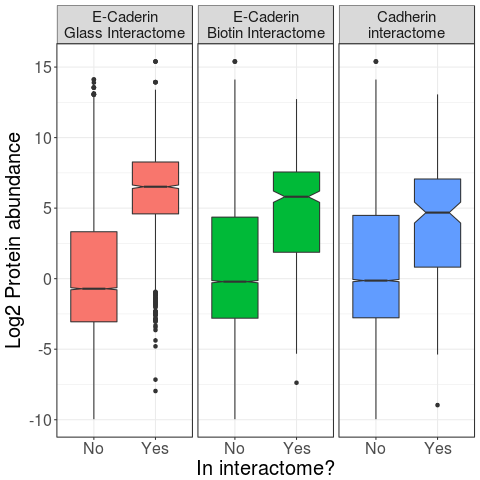

In [50]:
%%R -i merged_protein_df
library(ggplot2)
library(reshape2)
tmp_melt_df <- melt(merged_protein_df, measure.vars=c(
        'ecadherin_glass_interactome', 'ecadherin_biotin_interactome', 'cadherin_interactome'))

interactome_lables <- list(
  'ecadherin_glass_interactome'="E-Caderin\nGlass Interactome",
  'ecadherin_biotin_interactome'="E-Caderin\nBiotin Interactome",
  'cadherin_interactome'="Cadherin\ninteractome"
)

labels <- function(variable,value){
  return(interactome_lables[value])
}


m_txt = element_text(size=20)
s_txt = element_text(size=15)
p = ggplot(tmp_melt_df, aes(factor(value), log2(integrated_abundance), fill=factor(variable))) +
scale_fill_discrete(guide=F) +
geom_boxplot(notch=T) +
theme_bw() +
theme(text=m_txt, strip.text=s_txt) +
facet_wrap(~variable, labeller=labels) +
scale_x_discrete(label=c("No", "Yes")) +
ylab("Log2 Protein abundance") +
xlab("In interactome?")
ggsave("../plots.dir/Adbundance_interactome_relationship_box.png")
print(p)

In [13]:
def countOccurance(df, proteins):
    matched = set()
    for x in df.index:
        for p in proteins:
            if p in x or x in p:
                matched.add(x)
    
    return len(matched)

                
                
    return sum(df.index.isin(proteins))

def getRanks(df, proteins):
    matched_index = set()
    
    rank_df = df.filter(regex='rank', axis=1)
    
    for x in df.index:
        for p in proteins:
            if p in x or x in p:
                matched_index.add(x)
    
    return rank_df.loc[matched_index].iloc[:,0].tolist()

In [14]:
bins = np.arange(0,4,0.5)
print(bins)
print(np.digitize([0,1,2,3,4,4.2], bins=bins))

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5]
[1 3 5 7 8 8]


In [15]:
iterations = 10000

interactome2interactomeDF = {"high_quality": cadherin_interactome_df,
                             "biotin": ecadherin_biotin_interactome_df,
                             "glass": ecadherin_glass_interactome_df}

short_redf2abundanceDF = {'Sol': full_abundance_df,
                          'Weinert': liver_abundance_df,
                          'Rardin': liver_abundance_df,
                          'Sadhukhan': heart_abundance_df,
                          'Park': full_abundance_df,
                          'Nishida': liver_abundance_df,
                          'Colaka': liver_abundance_df,
                          'Tan': liver_abundance_df}

rows = []
rows2 = []

observed_column = []
rank_column = []
modification_column = []
reference_column = []
interactome_column = []

for modification in ["succinylation", "malonylation", "acetylation", "glutarylation"]:
    print("\n\n%s\n================================" % modification)
    for reference in set(lysine_protein_study_df['Reference']):
        
        if reference in ["nan", np.nan, "NA"]:
            continue
            
        print("---------%s---------" % reference)
        
        ref_short = reference.split("_")[0]
        abundance_df = short_redf2abundanceDF[ref_short]
        for interactome in ["high_quality", "biotin", "glass"]:
            add_ranks = False
            tmp_df = lysine_protein_study_df[lysine_protein_study_df['Reference']==reference]
            tmp_df = tmp_df[tmp_df[modification]>0]
            abundance_dist = abundance_df.ix[tmp_df['Protein']]['binned_abundance'].value_counts()

            # how many modidied proteins are in the interactome?
            reference_counts = countOccurance(interactome2interactomeDF[interactome],
                                              tmp_df['Protein'])
            
            if reference_counts > 0: # at least one observed case
                
                if interactome != 'high_quality': # no ranks for high_quality (binary)
                    reference_ranks = getRanks(interactome2interactomeDF[interactome],
                                               tmp_df['Protein'])
                    if len(reference_ranks) > 10: # check there are at least 10 observed cases for observed dist.
                        add_ranks = True
                        rank_column.extend(reference_ranks)
                        modification_column.extend((modification,)*len(reference_ranks))
                        reference_column.extend((ref_short,)*len(reference_ranks))
                        interactome_column.extend((interactome,)*len(reference_ranks))
                        observed_column.extend(("observed",)*len(reference_ranks))
                    
                null_counts = []
                for iteration in range(0, iterations): # derive null expectation from n iterations
                    
                    null_proteins = []
                    
                    for abundance_bin, count in abundance_dist.items():
                        # all proteins in bin
                        proteins = list(abundance_df[
                            abundance_df['binned_abundance']==abundance_bin].index)
                        # randomly choose proteins
                        chosen_proteins = np.random.choice(proteins, count, replace=False)
                        null_proteins.extend(chosen_proteins)
                    
                    # how many null proteins are in the interactome?
                    null_count = countOccurance(interactome2interactomeDF[interactome], null_proteins)
                    
                    null_counts.append(null_count)
                    rows2.append((modification, ref_short, interactome, reference_counts, null_count))
                    
                    # only add null ranks when observed ranks added
                    if add_ranks:
                        null_ranks = getRanks(interactome2interactomeDF[interactome], null_proteins)

                        rank_column.extend(null_ranks)
                        modification_column.extend((modification,)*len(null_ranks))
                        reference_column.extend((ref_short,)*len(null_ranks))
                        interactome_column.extend((interactome,)*len(null_ranks))
                        observed_column.extend(("null",)*len(null_ranks))
                            
                observed_more_than_null = len([x for x in null_counts if reference_counts > x])
                p = 1 - (observed_more_than_null/iterations)
                print("%s: p-value: %f (%i/%i), (%i/%i) vs %f +/- %f" %  (
                        interactome, p, observed_more_than_null, iterations, reference_counts,
                        len(tmp_df), np.mean(null_counts), np.std(null_counts)))
                print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
                rows.append((modification, ref_short, interactome,
                             p, iterations, reference_counts,
                             len(tmp_df), np.mean(null_counts), np.std(null_counts)))
            else:
                pass # no observed cases




succinylation
---------Weinert_et_al_2013---------


KeyboardInterrupt: 

In [ ]:
%%

In [ ]:
header = ["modification", "reference", "interactome", "p-value", "iterations",
          "observations", "cases", "null_mean", "null_std"]
empirical_p_df = pd.DataFrame.from_records(rows, columns=header)

header = ["modification", "reference", "interactome", "observed", "null"]
iterations_df = pd.DataFrame.from_records(rows2, columns=header)
print(empirical_p_df.head())
print(iterations_df.head())


ranks_df = pd.DataFrame({"observed": observed_column,
                         "rank":rank_column,
                         "modification":modification_column,
                         "interactome":interactome_column,
                         "reference": reference_column})
print(ranks_df.head())

In [ ]:
tmp_df = iterations_df[iterations_df['modification']=='succinylation']
tmp_df = tmp_df[tmp_df['reference']=="Park"]
tmp_df = tmp_df[tmp_df['interactome']=="biotin"]
print(tmp_df.head())

In [ ]:
%%R -i empirical_p_df
empirical_p_df['fdr'] <- p.adjust(empirical_p_df$p.value, method="BH")
empirical_p_df['enrichment'] = empirical_p_df['observations'] / empirical_p_df['null_mean']
print(empirical_p_df[empirical_p_df$fdr<0.1,])

In [ ]:
%%R -i tmp_df
library(ggplot2)

txt <- element_text(size=20)
my_theme <- theme(
text = txt)

print(head(tmp_df))
p <- ggplot(tmp_df, aes(null)) +
geom_density() +
geom_vline(xintercept = tmp_df$observed[1], color='red', size=1) +
theme_bw() +
my_theme +
xlab("Number of E-cadherin \nBiotin Interactome proteins") +
ylab("Density")


print(p)
ggsave("../plots.dir/example_emperical_p.png")

In [ ]:
%%R -i ranks_df 
print(colnames(ranks_df))

run_ks_test = function(foreground, background, plotfile='', title=''){

ks = ks.test(foreground,background,alternative="greater")
print(ks)    
    
sample1 <- foreground
sample2 <- background
group <- c(rep("sample1", length(sample1)), rep("sample2", length(sample2)))
dat <- data.frame(KSD = c(sample1,sample2), group = group)

cdf1 <- ecdf(sample1) 
cdf2 <- ecdf(sample2) 

minMax <- seq(min(sample1, sample2), max(sample1, sample2), length.out=length(sample1)) 
x0 <- minMax[which( abs(cdf1(minMax) - cdf2(minMax)) == max(abs(cdf1(minMax) - cdf2(minMax))) )] 
y0 <- cdf1(x0) 
y1 <- cdf2(x0) 

p = ggplot(dat, aes(x = KSD, group = group, color = group))+
  stat_ecdf(size=1) +
    theme_bw(base_size = 20) +
    theme(legend.position ="right") +
    xlab("Protein rank") +
    ylab("ECDF") +
    #geom_line(size=1) +
    geom_segment(aes(x = x0[1], y = y0[1], xend = x0[1], yend = y1[1]),
        linetype = "dashed", color = "black") +
    geom_point(aes(x = x0[1] , y= y0[1]), color="black", size=2) +
    geom_point(aes(x = x0[1] , y= y1[1]), color="black", size=2) +
    ggtitle(paste0(title, ":\nK-S Test. D:", round(ks$statistic, 2),
                   ' p-value: ', round(ks$p.value, 5)))+
    theme(legend.title=element_blank(), aspect.ratio=1) +
    scale_colour_discrete(labels=c('modified', 'unmodified'))

ggsave(plotfile)
    
if(ks$p.value<0.05){
plot(p)
p = ggplot(dat, aes(x = KSD, group = group, color = group))+
    geom_density(size=1) +
    theme_bw(base_size = 20) +
    theme(legend.position ="right") +
    xlab("Protein rank") +
    ylab("Density") +
    ggtitle(paste0(title, ":\nK-S Test. D:", round(ks$statistic, 2),
                   ' p-value: ', round(ks$p.value, 5)))+
    theme(legend.title=element_blank(), aspect.ratio=1) +
    scale_colour_discrete(labels=c('modified', 'unmodified'))

plot(p)
    
}

}

for (modification in unique(ranks_df$modification)){
    tmp_df <- ranks_df[ranks_df['modification']==modification,]
    
    for (reference in unique(tmp_df$reference)){
        tmp_df2 <- tmp_df[tmp_df['reference']==reference,]
            
        for (interactome in unique(tmp_df2$interactome)){
            tmp_df3 <- tmp_df2[tmp_df2['interactome']==interactome,]
            
            observed = tmp_df3[tmp_df3['observed']=="observed","rank"]
            null = tmp_df3[tmp_df3['observed']=="null","rank"]

            title = paste(reference, modification, interactome, sep="-")
            
            run_ks_test(observed, null,
                        paste0("../plots.dir/ECDF_abundance_controlled_", title, ".png"),
                        title)
        }
    }
}


In [ ]:
iterations = 10000

interactome2interactomeDF = {"high_quality": cadherin_interactome_df,
                             "biotin": ecadherin_biotin_interactome_df,
                             "glass": ecadherin_glass_interactome_df}

short_redf2abundanceDF = {'Sol': mef_abundance_df,
                          'Weinert': liver_abundance_df,
                          'Rardin': liver_abundance_df,
                          'Sadhukhan': heart_abundance_df,
                          'Park': mef_abundance_df,
                          'Nishida': liver_abundance_df,
                          'Colaka': liver_abundance_df,
                          'Tan': liver_abundance_df}

rows2 = []
rows22 = []

observed_column2 = []
rank_column2 = []
modification_column2 = []
reference_column2 = []
interactome_column2 = []

for modification in ["succinylation", "malonylation", "acetylation", "glutarylation"]:
    print("\n\n%s\n================================" % modification)
    for reference in set(merged_protein_df['Reference']):
        
        ref_short = reference.split("_")[0]
        
        if ref_short not in ["Sol", "Park"]:
            continue
            
        print("---------%s---------" % reference)
        
        
        abundance_df = short_redf2abundanceDF[ref_short]
        for interactome in ["high_quality", "biotin", "glass"]:
            add_ranks = False
            tmp_df = merged_protein_df[merged_protein_df['Reference']==reference]
            tmp_df = tmp_df[tmp_df[modification]>0]
            abundance_dist = abundance_df.ix[tmp_df['uniprot.accession']]['binned_abundance'].value_counts()

            # how many modidied proteins are in the interactome?
            reference_counts = countOccurance(interactome2interactomeDF[interactome],
                                              tmp_df['uniprot.accession'])
            
            if reference_counts > 0: # at least one observed case
                
                if interactome != 'high_quality': # no ranks for high_quality (binary)
                    reference_ranks = getRanks(interactome2interactomeDF[interactome],
                                               tmp_df['uniprot.accession'])
                    if len(reference_ranks) > 10: # check there are at least 10 observed cases for observed dist.
                        add_ranks = True
                        rank_column2.extend(reference_ranks)
                        modification_column2.extend((modification,)*len(reference_ranks))
                        reference_column2.extend((ref_short,)*len(reference_ranks))
                        interactome_column2.extend((interactome,)*len(reference_ranks))
                        observed_column2.extend(("observed",)*len(reference_ranks))
                    
                null_counts = []
                for iteration in range(0, iterations): # derive null expectation from n iterations
                    
                    null_proteins = []
                    
                    for abundance_bin, count in abundance_dist.items():
                        # all proteins in bin
                        proteins = list(abundance_df[
                            abundance_df['binned_abundance']==abundance_bin].index)
                        # randomly choose proteins
                        chosen_proteins = np.random.choice(proteins, count, replace=False)
                        null_proteins.extend(chosen_proteins)
                    
                    # how many null proteins are in the interactome?
                    null_count = countOccurance(interactome2interactomeDF[interactome], null_proteins)
                    
                    null_counts.append(null_count)
                    rows22.append((modification, ref_short, interactome, reference_counts, null_count))
                    
                    # only add null ranks when observed ranks added
                    if add_ranks:
                        null_ranks = getRanks(interactome2interactomeDF[interactome], null_proteins)

                        rank_column2.extend(null_ranks)
                        modification_column2.extend((modification,)*len(null_ranks))
                        reference_column2.extend((ref_short,)*len(null_ranks))
                        interactome_column2.extend((interactome,)*len(null_ranks))
                        observed_column2.extend(("null",)*len(null_ranks))
                            
                observed_more_than_null = len([x for x in null_counts if reference_counts > x])
                p = 1 - (observed_more_than_null/iterations)
                print("%s: p-value: %f (%i/%i), (%i/%i) vs %f +/- %f" %  (
                        interactome, p, observed_more_than_null, iterations, reference_counts,
                        len(tmp_df), np.mean(null_counts), np.std(null_counts)))
                print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
                rows2.append((modification, ref_short, interactome,
                             p, iterations, reference_counts,
                             len(tmp_df), np.mean(null_counts), np.std(null_counts)))
            else:
                pass # no observed cases


In [ ]:
header = ["modification", "reference", "interactome", "p-value", "iterations",
          "observations", "cases", "null_mean", "null_std"]
empirical_p_df2 = pd.DataFrame.from_records(rows, columns=header)

header = ["modification", "reference", "interactome", "observed", "null"]
iterations_df2 = pd.DataFrame.from_records(rows22, columns=header)
print(empirical_p_df2.head())
print(iterations_df2.head())


ranks_df2 = pd.DataFrame({"observed": observed_column2,
                         "rank":rank_column2,
                         "modification":modification_column2,
                         "interactome":interactome_column2,
                         "reference": reference_column2})
print(ranks_df2.head())

In [ ]:
%%R -i ranks_df2 
print(colnames(ranks_df2))

run_ks_test = function(foreground, background, plotfile='', title=''){

ks = ks.test(foreground,background,alternative="greater")
print(ks)    
    
sample1 <- foreground
sample2 <- background
group <- c(rep("sample1", length(sample1)), rep("sample2", length(sample2)))
dat <- data.frame(KSD = c(sample1,sample2), group = group)

cdf1 <- ecdf(sample1) 
cdf2 <- ecdf(sample2) 

minMax <- seq(min(sample1, sample2), max(sample1, sample2), length.out=length(sample1)) 
x0 <- minMax[which( abs(cdf1(minMax) - cdf2(minMax)) == max(abs(cdf1(minMax) - cdf2(minMax))) )] 
y0 <- cdf1(x0) 
y1 <- cdf2(x0) 

p = ggplot(dat, aes(x = KSD, group = group, color = group))+
  stat_ecdf(size=1) +
    theme_bw(base_size = 20) +
    theme(legend.position ="right") +
    xlab("Protein rank") +
    ylab("ECDF") +
    #geom_line(size=1) +
    geom_segment(aes(x = x0[1], y = y0[1], xend = x0[1], yend = y1[1]),
        linetype = "dashed", color = "black") +
    geom_point(aes(x = x0[1] , y= y0[1]), color="black", size=2) +
    geom_point(aes(x = x0[1] , y= y1[1]), color="black", size=2) +
    ggtitle(paste0(title, ":\nK-S Test. D:", round(ks$statistic, 2),
                   ' p-value: ', round(ks$p.value, 5)))+
    theme(legend.title=element_blank(), aspect.ratio=1) +
    scale_colour_discrete(labels=c('modified', 'unmodified'))

ggsave(plotfile)
    
if(ks$p.value<0.05){
plot(p)
p = ggplot(dat, aes(x = KSD, group = group, color = group))+
    geom_density(size=1) +
    theme_bw(base_size = 20) +
    theme(legend.position ="right") +
    xlab("Protein rank") +
    ylab("Density") +
    ggtitle(paste0(title, ":\nK-S Test. D:", round(ks$statistic, 2),
                   ' p-value: ', round(ks$p.value, 5)))+
    theme(legend.title=element_blank(), aspect.ratio=1) +
    scale_colour_discrete(labels=c('modified', 'unmodified'))

plot(p)
    
plot(density(sample1))
plot(density(sample2))
}

}

for (modification in unique(ranks_df2$modification)){
    tmp_df <- ranks_df2[ranks_df2['modification']==modification,]
    
    for (reference in unique(tmp_df$reference)){
        tmp_df2 <- tmp_df[tmp_df['reference']==reference,]
            
        for (interactome in unique(tmp_df2$interactome)){
            tmp_df3 <- tmp_df2[tmp_df2['interactome']==interactome,]
            
            observed = tmp_df3[tmp_df3['observed']=="observed","rank"]
            null = tmp_df3[tmp_df3['observed']=="null","rank"]

            title = paste(reference, modification, interactome, sep="-")
            
            run_ks_test(observed, null,
                        paste0("../plots.dir/ECDF_abundance_mef_controlled_", title, ".png"),
                        title)
        }
    }
}


Ok, so we've demonstrated an enrichment for succinylation and acetylation in all cadherin interactomes in the MEF lines. Now we want to see whether the cadherin interactome proteins have a different SIRT KO ratio to all other proteins. Since the same enrichment was not obvious with the liver samples, the hypothesis is that acylation inhibits the proteins involvement with cell cell adhesion and the proteins should therefore show a low ratio, i.e not regulated by SIRT3/5. However, it's also possible that the acylations are still regulated by SIRT3/5 in MEFs so it's not clear what we might expect.


In [16]:
print(lysine_df.shape)
lysine_interactome_df = pd.merge(lysine_df, cadherin_interactome_df, left_on="Protein",
                                 right_index=True, how="left")
print(lysine_interactome_df.shape)

lysine_interactome_df = pd.merge(lysine_interactome_df, ecadherin_biotin_interactome_df, left_on="Protein",
                                 right_index=True, how="left")

print(lysine_interactome_df.shape)

lysine_interactome_df = pd.merge(lysine_interactome_df, ecadherin_glass_interactome_df, left_on="Protein",
                                 right_index=True, how="left")
lysine_interactome_df.fillna(0, inplace=True)
print(lysine_interactome_df.head())

(19267, 6)
(19267, 7)
(19267, 10)
  Protein  Position   Modification             Reference  ratio  p_value  \
0  Q9JLT4       337  succinylation  Sadhukhan_et_al_2016   1.47     -1.0   
1  Q61425       179  succinylation  Sadhukhan_et_al_2016   1.07     -1.0   
2  Q61425       241  succinylation  Sadhukhan_et_al_2016   1.33     -1.0   
3  Q9JLZ3       179  succinylation  Sadhukhan_et_al_2016   4.70     -1.0   
4  Q9CZU6       450  succinylation  Sadhukhan_et_al_2016  57.68     -1.0   

   cadherin_interactome  ecadherin_biotin_interactome  \
0                   0.0                           0.0   
1                   0.0                           0.0   
2                   0.0                           0.0   
3                   0.0                           0.0   
4                   0.0                           0.0   

   biotin_interactome_abundance  biotin_rank  ecadherin_glass_interactome  \
0                           0.0          0.0                          0.0   
1           

In [17]:
%%R -i lysine_interactome_df
print(table(lysine_interactome_df$Reference, lysine_interactome_df$cadherin_interactome))
print(table(lysine_interactome_df$Reference, lysine_interactome_df$ecadherin_biotin_interactome))
print(table(lysine_interactome_df$Reference, lysine_interactome_df$ecadherin_glass_interactome))

                      
                          0    1
  Colaka_et_al_2015    4118   91
  Nishida_et_al_2015   1032   11
  Park_et_al_2013      1016   69
  Rardin_et_al_2013     996    0
  Sadhukhan_et_al_2016  119    0
  Sol_et_al_2012       4788   60
  Tan_et_al_2014        746    0
  Weinert_et_al_2013   6155   66
                      
                          0    1
  Colaka_et_al_2015    3883  326
  Nishida_et_al_2015    949   94
  Park_et_al_2013       942  143
  Rardin_et_al_2013     993    3
  Sadhukhan_et_al_2016  119    0
  Sol_et_al_2012       4653  195
  Tan_et_al_2014        744    2
  Weinert_et_al_2013   5964  257
                      
                          0    1
  Colaka_et_al_2015    2842 1367
  Nishida_et_al_2015    729  314
  Park_et_al_2013       651  434
  Rardin_et_al_2013     810  186
  Sadhukhan_et_al_2016   91   28
  Sol_et_al_2012       4176  672
  Tan_et_al_2014        653   93
  Weinert_et_al_2013   4677 1544


  Protein Position  Modification            Reference ratio p_value
0  Q9JLT4      337 succinylation Sadhukhan_et_al_2016  1.47      -1
1  Q61425      179 succinylation Sadhukhan_et_al_2016  1.07      -1
2  Q61425      241 succinylation Sadhukhan_et_al_2016  1.33      -1
3  Q9JLZ3      179 succinylation Sadhukhan_et_al_2016  4.70      -1
4  Q9CZU6      450 succinylation Sadhukhan_et_al_2016 57.68      -1
5  Q9CZU6       76 succinylation Sadhukhan_et_al_2016 19.67      -1
  cadherin_interactome ecadherin_biotin_interactome
0                    0                            0
1                    0                            0
2                    0                            0
3                    0                            0
4                    0                            0
5                    0                            0
  biotin_interactome_abundance biotin_rank ecadherin_glass_interactome
0                            0           0                           0
1                 

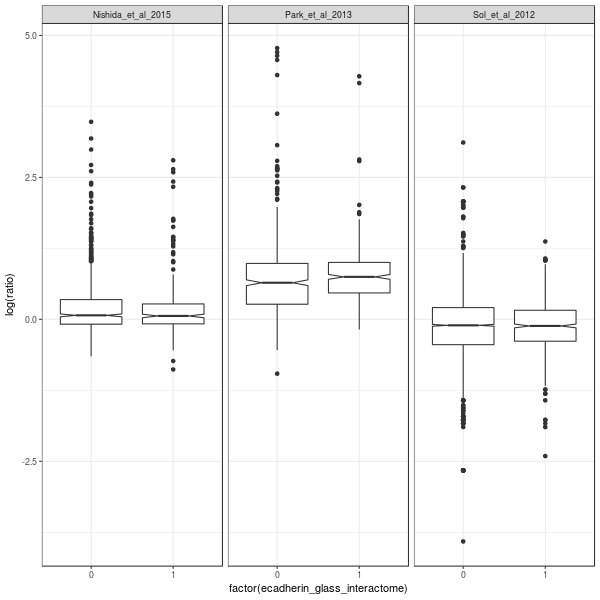

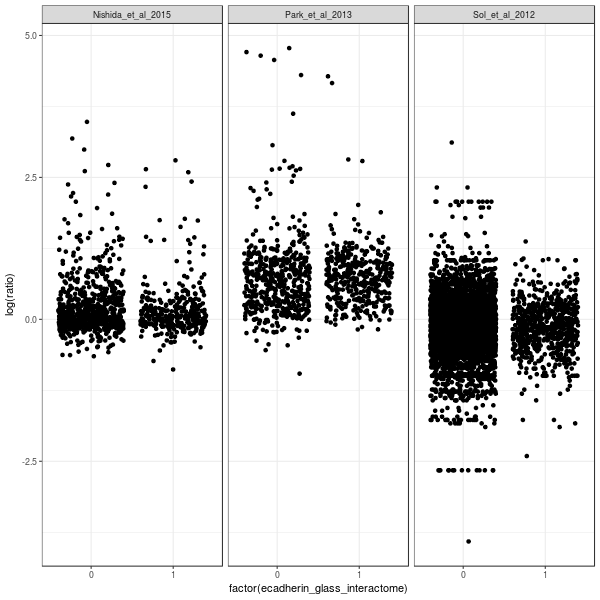

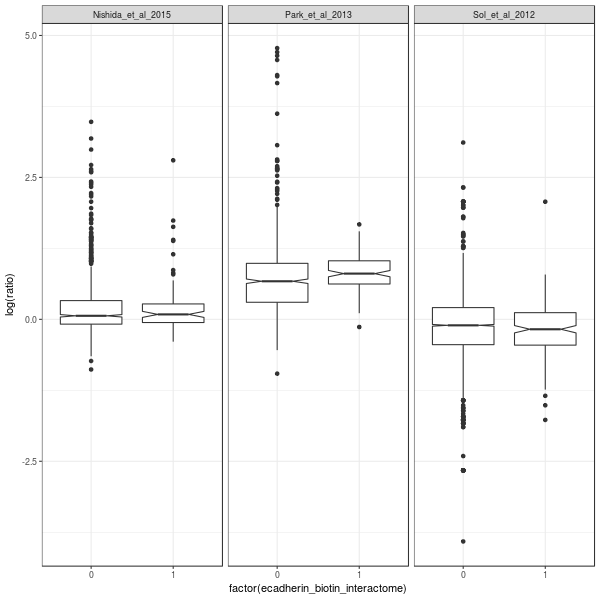

In [20]:
%%R -i lysine_interactome_df -w 600 -h 600
library(ggplot2)
print(head(lysine_interactome_df))

retain <- c("Sol_et_al_2012", "Park_et_al_2013", "Nishida_et_al_2015")
lysine_interactome_df <- lysine_interactome_df[lysine_interactome_df$Reference %in% retain,]

p <- ggplot(lysine_interactome_df, aes(factor(ecadherin_glass_interactome), log(ratio))) +
geom_boxplot(notch=TRUE) +
facet_wrap(~Reference) +
theme_bw()

print(p)

p <- ggplot(lysine_interactome_df, aes(factor(ecadherin_glass_interactome), log(ratio))) +
geom_jitter() +
facet_wrap(~Reference) +
theme_bw()

print(p)

p <- ggplot(lysine_interactome_df, aes(factor(ecadherin_biotin_interactome), log(ratio))) +
geom_boxplot(notch=TRUE) +
facet_wrap(~Reference) +
theme_bw()

print(p)



/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: notch went outside hinges. Try setting notch=FALSE.

  warnings.warn(x, RRuntimeWarning)


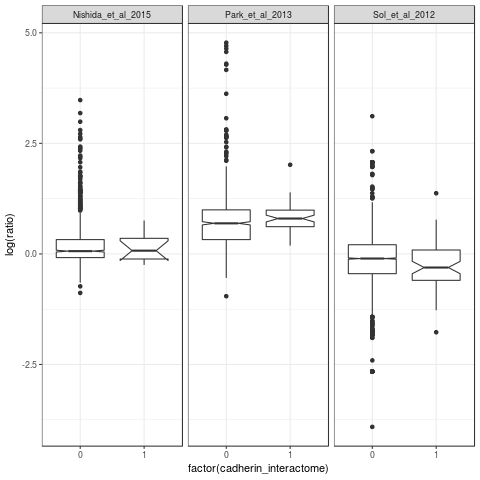

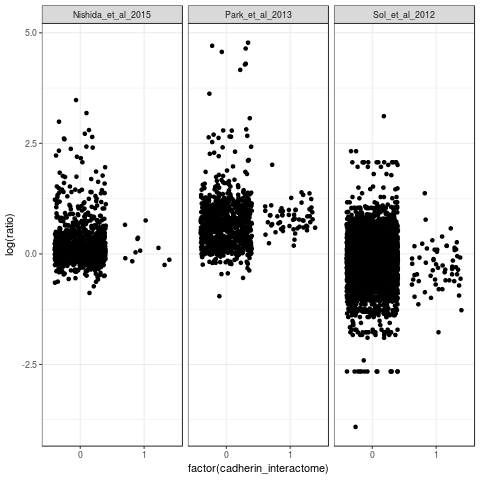

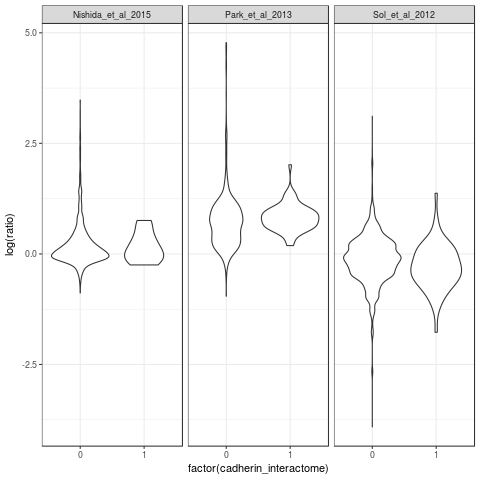

In [21]:
%%R
p <- ggplot(lysine_interactome_df, aes(factor(cadherin_interactome), log(ratio))) +
facet_wrap(~Reference) +
theme_bw()

p2 <- p + geom_boxplot(notch=TRUE)
p3 <- p + geom_jitter()
p4 <- p + geom_violin()

print(p2)
print(p3)
print(p4)

It doesn't look like the data supports the idea that SIRT3/5 is less active at the 

In [ ]:
print(lysine_interactome_df[lysine_interactome_df['Reference']=="Tan_et_al_2014"].head(2))
print(lysine_interactome_df[lysine_interactome_df['Reference']=="Sadhukhan_et_al_2016"].head(2))


In [ ]:
    #lysine_pivot = lysine_df.pivot_table(
    #    values='ratio', index=index, columns='Modification', aggfunc=lambda x: len(x)>0)
    #lysine_pivot = lysine_pivot.fillna(0)
    #lysine_pivot.reset_index(inplace=True)
    #lysine_pivot.columns.name = None

tmp_df = lysine_interactome_df[~lysine_interactome_df['Reference'].isin(
    ["Colaka_et_al_2015", "Tan_et_al_2014", "Weinert_et_al_2013", "Sadhukhan_et_al_2016"])]
                               
lysine_ratios_interactome_df = tmp_df[tmp_df['ecadherin_glass_interactome']==1].pivot_table(
    values='ratio', index=["Protein", "Position", "Modification"], columns='Reference')
#lysine_ratios_interactome_df = tmp_df[tmp_df['ecadherin_glass_interactome']==1].pivot_table(
#    values='ratio', index=["Protein", "Modification"], columns='Reference')


references = lysine_ratios_interactome_df.columns

lysine_ratios_interactome_df.reset_index(inplace=True)
lysine_ratios_interactome_df.columns.name=""

print(lysine_ratios_interactome_df.head())

succ_lysine_ratios_interactome_df = lysine_ratios_interactome_df[
    lysine_ratios_interactome_df['Modification']=="succinylation"]

print(succ_lysine_ratios_interactome_df.shape)

for reference in references:
        print(reference)
        if sum(np.isfinite(succ_lysine_ratios_interactome_df[reference])) == 0:
            succ_lysine_ratios_interactome_df.drop(reference, axis=1, inplace=True)

print(succ_lysine_ratios_interactome_df.shape)

succ_lysine_ratios_interactome_df = succ_lysine_ratios_interactome_df[
    succ_lysine_ratios_interactome_df.apply(lambda x: sum(x.isnull()), axis=1)==0]

print(succ_lysine_ratios_interactome_df.shape)
print(succ_lysine_ratios_interactome_df.head())

print(stats.ttest_rel(
    np.log(succ_lysine_ratios_interactome_df['Park_et_al_2013']),
    np.log(succ_lysine_ratios_interactome_df['Rardin_et_al_2013'])))

succ_lysine_ratios_interactome_df = pd.melt(
    succ_lysine_ratios_interactome_df, id_vars = ["Protein", "Position", "Modification"],
    var_name="Reference")



print(succ_lysine_ratios_interactome_df.shape)
print(succ_lysine_ratios_interactome_df.head())
#print(lysine_ratios_interactome_df.head())

In [ ]:

%%R -i succ_lysine_ratios_interactome_df

print(head(succ_lysine_ratios_interactome_df))

p <- ggplot(succ_lysine_ratios_interactome_df, aes(Reference, log(value,2))) +
theme_bw()

p_point <- p + geom_point(aes(colour=Protein))
p_density <- ggplot(succ_lysine_ratios_interactome_df, aes(log(value,2))) +
geom_density(aes(colour=Reference)) +
theme_bw()

p_jit <- p + geom_jitter()
p_box <- p + geom_boxplot(notch=T)
p_violin <- p + geom_violin()
p_line <- p + geom_line(aes(group=interaction(Protein, Position), colour=Protein))
#p_line <- p + geom_line(aes(group=Protein, colour=Protein)) + geom_point(aes(colour=Protein))

print(p_density)
print(p_line)
print(p_box)
print(p_violin)
print(p_point)
print(p_jit)


In [ ]:
%%R -i lysine_interactome_df -w 600 -h 600
print(head(lysine_interactome_df))


tmp_df <- lysine_interactome_df[lysine_interactome_df$cadherin_interactome==1,]
print(head(tmp_df))